# **Implementation of Generative Adversarial Networks (GAN)**

In [ ]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
class DCGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z) # g(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img) # D(G(z))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        # 100 -> 256 -> 512 -> 1024 -> 28*28*1
        model = Sequential()

        model.add(Dense(128*7*7, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))

        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))

        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))

        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation('tanh'))

        model.summary()

        noise = Input(shape=(self.latent_dim,)) #z
        img = model(noise)

        return Model(noise, img) # G Model

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
        model.add(ZeroPadding2D(padding=((0,1), (0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())

        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape) #x
        validity = model(img) #D(x)

        return Model(img, validity) # D model

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train/127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            # shape: batch_size*28*28*1
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            # Shape: 32*28*28*1
            gen_imgs = self.generator.predict(noise) # batch of G(z)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid) # D(x)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake) # D(G(z))
            d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid) # G loss

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.savefig("gan_%d.png" % epoch)
        plt.show()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d_2 (ZeroPaddi  (None, 8, 8, 64)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

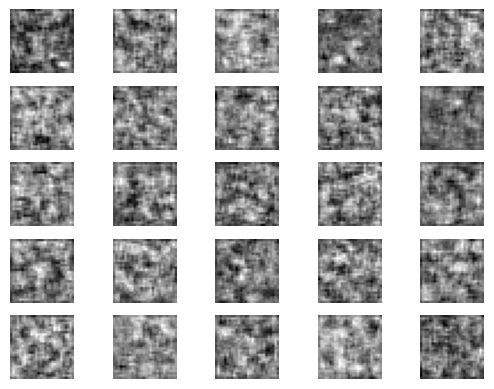

4/4 [==============================] - 0s 3ms/step
1 [D loss: 0.765327, acc.: 58.98%] [G loss: 0.620711]
4/4 [==============================] - 0s 3ms/step
2 [D loss: 0.428915, acc.: 79.69%] [G loss: 0.635609]
4/4 [==============================] - 0s 4ms/step
3 [D loss: 0.218826, acc.: 96.09%] [G loss: 0.648940]
4/4 [==============================] - 0s 5ms/step
4 [D loss: 0.125678, acc.: 99.22%] [G loss: 0.629100]
4/4 [==============================] - 0s 3ms/step
5 [D loss: 0.116738, acc.: 98.83%] [G loss: 0.595146]
4/4 [==============================] - 0s 4ms/step
6 [D loss: 0.137756, acc.: 97.27%] [G loss: 0.527528]
4/4 [==============================] - 0s 3ms/step
7 [D loss: 0.212164, acc.: 94.14%] [G loss: 0.632680]
4/4 [==============================] - 0s 3ms/step
8 [D loss: 0.418746, acc.: 79.69%] [G loss: 1.269154]
4/4 [==============================] - 0s 3ms/step
9 [D loss: 0.599124, acc.: 67.19%] [G loss: 2.097922]
4/4 [==============================] - 0s 3ms/step
10 [

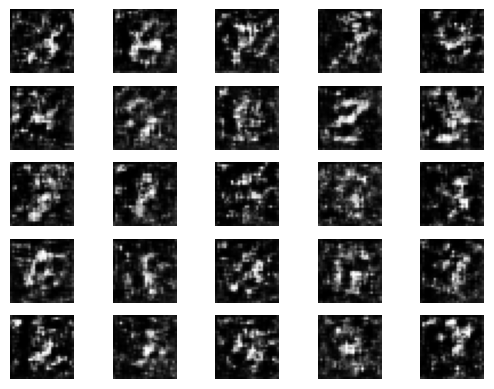

4/4 [==============================] - 0s 3ms/step
51 [D loss: 0.867489, acc.: 53.52%] [G loss: 1.017842]
4/4 [==============================] - 0s 5ms/step
52 [D loss: 0.882291, acc.: 46.48%] [G loss: 0.876876]
4/4 [==============================] - 0s 5ms/step
53 [D loss: 0.734989, acc.: 57.03%] [G loss: 0.880102]
4/4 [==============================] - 0s 4ms/step
54 [D loss: 0.582266, acc.: 67.19%] [G loss: 0.891058]
4/4 [==============================] - 0s 4ms/step
55 [D loss: 0.817475, acc.: 52.73%] [G loss: 1.039280]
4/4 [==============================] - 0s 4ms/step
56 [D loss: 0.840646, acc.: 50.39%] [G loss: 1.014274]
4/4 [==============================] - 0s 4ms/step
57 [D loss: 0.692035, acc.: 59.38%] [G loss: 1.162322]
4/4 [==============================] - 0s 4ms/step
58 [D loss: 0.614762, acc.: 67.97%] [G loss: 0.943849]
4/4 [==============================] - 0s 4ms/step
59 [D loss: 0.591861, acc.: 69.14%] [G loss: 0.820376]
4/4 [==============================] - 0s 3ms/

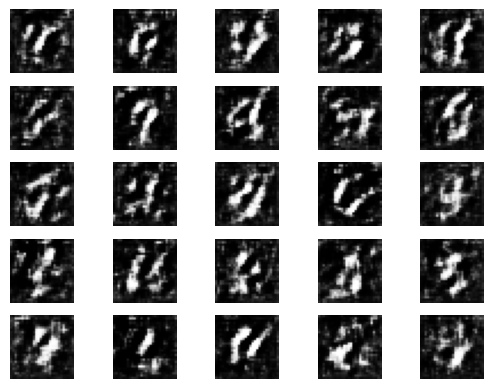

4/4 [==============================] - 0s 4ms/step
101 [D loss: 0.710497, acc.: 61.33%] [G loss: 0.907622]
4/4 [==============================] - 0s 5ms/step
102 [D loss: 0.641640, acc.: 64.45%] [G loss: 0.857891]
4/4 [==============================] - 0s 4ms/step
103 [D loss: 0.708564, acc.: 57.42%] [G loss: 1.007174]
4/4 [==============================] - 0s 5ms/step
104 [D loss: 0.779911, acc.: 50.39%] [G loss: 0.987257]
4/4 [==============================] - 0s 3ms/step
105 [D loss: 0.687458, acc.: 60.94%] [G loss: 0.999069]
4/4 [==============================] - 0s 5ms/step
106 [D loss: 0.804372, acc.: 50.39%] [G loss: 0.967069]
4/4 [==============================] - 0s 5ms/step
107 [D loss: 0.694020, acc.: 59.38%] [G loss: 1.014181]
4/4 [==============================] - 0s 5ms/step
108 [D loss: 0.734288, acc.: 52.34%] [G loss: 0.940986]
4/4 [==============================] - 0s 5ms/step
109 [D loss: 0.854279, acc.: 42.58%] [G loss: 0.940688]
4/4 [==============================] 

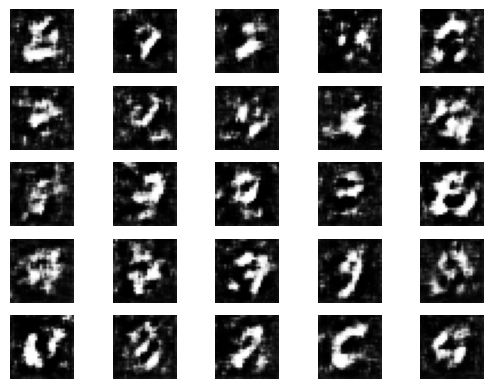

4/4 [==============================] - 0s 4ms/step
151 [D loss: 0.722282, acc.: 53.12%] [G loss: 0.862427]
4/4 [==============================] - 0s 6ms/step
152 [D loss: 0.667686, acc.: 58.59%] [G loss: 0.965798]
4/4 [==============================] - 0s 6ms/step
153 [D loss: 0.774662, acc.: 50.78%] [G loss: 0.844504]
4/4 [==============================] - 0s 6ms/step
154 [D loss: 0.661160, acc.: 64.84%] [G loss: 0.930630]
4/4 [==============================] - 0s 5ms/step
155 [D loss: 0.690246, acc.: 55.47%] [G loss: 0.919692]
4/4 [==============================] - 0s 7ms/step
156 [D loss: 0.577776, acc.: 71.09%] [G loss: 0.847922]
4/4 [==============================] - 0s 4ms/step
157 [D loss: 0.688155, acc.: 60.16%] [G loss: 0.926960]
4/4 [==============================] - 0s 6ms/step
158 [D loss: 0.726495, acc.: 51.95%] [G loss: 0.957867]
4/4 [==============================] - 0s 4ms/step
159 [D loss: 0.724703, acc.: 51.95%] [G loss: 0.957632]
4/4 [==============================] 

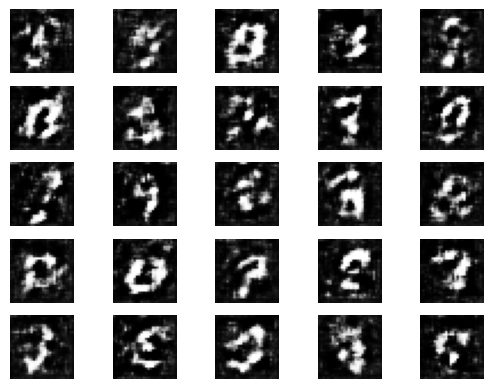

4/4 [==============================] - 0s 4ms/step
201 [D loss: 0.726912, acc.: 54.69%] [G loss: 0.902514]
4/4 [==============================] - 0s 6ms/step
202 [D loss: 0.714092, acc.: 54.69%] [G loss: 0.855104]
4/4 [==============================] - 0s 4ms/step
203 [D loss: 0.687565, acc.: 58.20%] [G loss: 0.927516]
4/4 [==============================] - 0s 6ms/step
204 [D loss: 0.760950, acc.: 50.39%] [G loss: 0.903907]
4/4 [==============================] - 0s 3ms/step
205 [D loss: 0.767808, acc.: 48.83%] [G loss: 0.860415]
4/4 [==============================] - 0s 4ms/step
206 [D loss: 0.800402, acc.: 42.97%] [G loss: 0.797419]
4/4 [==============================] - 0s 3ms/step
207 [D loss: 0.779405, acc.: 48.44%] [G loss: 0.845198]
4/4 [==============================] - 0s 4ms/step
208 [D loss: 0.689762, acc.: 59.38%] [G loss: 0.743523]
4/4 [==============================] - 0s 6ms/step
209 [D loss: 0.763891, acc.: 49.22%] [G loss: 0.869831]
4/4 [==============================] 

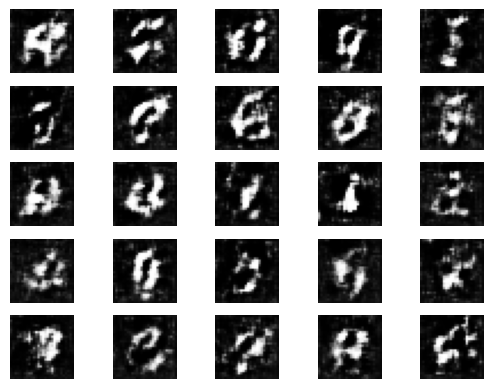

4/4 [==============================] - 0s 5ms/step
251 [D loss: 0.766958, acc.: 46.48%] [G loss: 0.915087]
4/4 [==============================] - 0s 5ms/step
252 [D loss: 0.686412, acc.: 56.25%] [G loss: 0.795493]
4/4 [==============================] - 0s 6ms/step
253 [D loss: 0.720588, acc.: 53.91%] [G loss: 0.885600]
4/4 [==============================] - 0s 4ms/step
254 [D loss: 0.606933, acc.: 66.80%] [G loss: 0.860355]
4/4 [==============================] - 0s 5ms/step
255 [D loss: 0.590631, acc.: 69.53%] [G loss: 0.855833]
4/4 [==============================] - 0s 4ms/step
256 [D loss: 0.627600, acc.: 63.28%] [G loss: 0.869323]
4/4 [==============================] - 0s 3ms/step
257 [D loss: 0.724283, acc.: 51.95%] [G loss: 0.849132]
4/4 [==============================] - 0s 5ms/step
258 [D loss: 0.692016, acc.: 58.20%] [G loss: 0.904936]
4/4 [==============================] - 0s 3ms/step
259 [D loss: 0.680164, acc.: 58.98%] [G loss: 0.965806]
4/4 [==============================] 

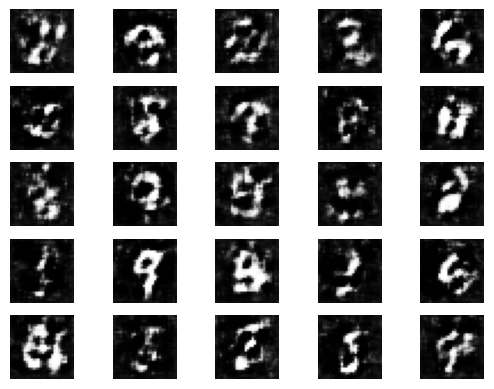

4/4 [==============================] - 0s 3ms/step
301 [D loss: 0.553576, acc.: 73.44%] [G loss: 0.856093]
4/4 [==============================] - 0s 4ms/step
302 [D loss: 0.467464, acc.: 83.20%] [G loss: 0.856528]
4/4 [==============================] - 0s 9ms/step
303 [D loss: 0.635254, acc.: 64.45%] [G loss: 0.910121]
4/4 [==============================] - 0s 5ms/step
304 [D loss: 0.589351, acc.: 66.41%] [G loss: 0.911011]
4/4 [==============================] - 0s 7ms/step
305 [D loss: 0.585454, acc.: 69.92%] [G loss: 0.922276]
4/4 [==============================] - 0s 8ms/step
306 [D loss: 0.675232, acc.: 60.94%] [G loss: 0.847056]
4/4 [==============================] - 0s 3ms/step
307 [D loss: 0.687796, acc.: 58.20%] [G loss: 0.859856]
4/4 [==============================] - 0s 6ms/step
308 [D loss: 0.821296, acc.: 45.31%] [G loss: 0.864385]
4/4 [==============================] - 0s 3ms/step
309 [D loss: 0.606257, acc.: 67.97%] [G loss: 0.862371]
4/4 [==============================] 

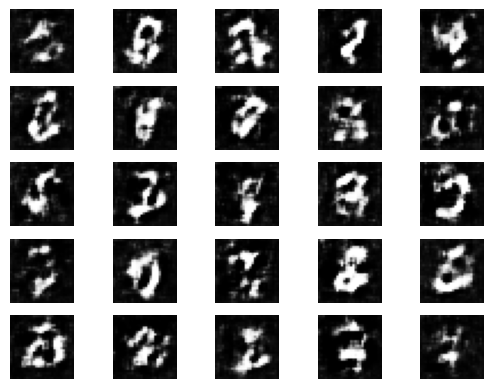

4/4 [==============================] - 0s 5ms/step
351 [D loss: 0.666714, acc.: 61.33%] [G loss: 0.880149]
4/4 [==============================] - 0s 4ms/step
352 [D loss: 0.624366, acc.: 67.19%] [G loss: 0.910382]
4/4 [==============================] - 0s 4ms/step
353 [D loss: 0.697959, acc.: 57.81%] [G loss: 0.869972]
4/4 [==============================] - 0s 3ms/step
354 [D loss: 0.534421, acc.: 75.78%] [G loss: 0.854398]
4/4 [==============================] - 0s 5ms/step
355 [D loss: 0.472528, acc.: 78.91%] [G loss: 0.872820]
4/4 [==============================] - 0s 6ms/step
356 [D loss: 0.516996, acc.: 77.34%] [G loss: 0.771037]
4/4 [==============================] - 0s 5ms/step
357 [D loss: 0.553187, acc.: 74.61%] [G loss: 0.864381]
4/4 [==============================] - 0s 6ms/step
358 [D loss: 0.480645, acc.: 78.52%] [G loss: 0.907982]
4/4 [==============================] - 0s 4ms/step
359 [D loss: 0.490590, acc.: 81.25%] [G loss: 0.976146]
4/4 [==============================] 

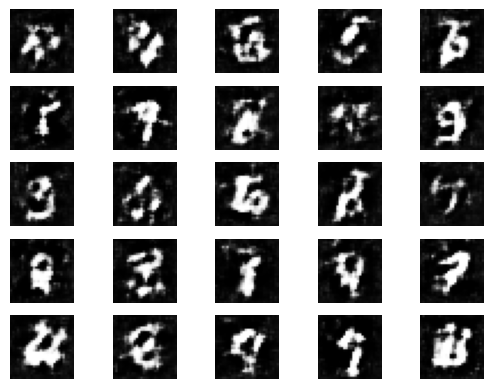

4/4 [==============================] - 0s 6ms/step
401 [D loss: 0.744939, acc.: 50.39%] [G loss: 0.846167]
4/4 [==============================] - 0s 5ms/step
402 [D loss: 0.518809, acc.: 75.78%] [G loss: 0.807737]
4/4 [==============================] - 0s 6ms/step
403 [D loss: 0.519167, acc.: 78.52%] [G loss: 0.823144]
4/4 [==============================] - 0s 7ms/step
404 [D loss: 0.560427, acc.: 72.27%] [G loss: 0.885265]
4/4 [==============================] - 0s 4ms/step
405 [D loss: 0.499510, acc.: 78.52%] [G loss: 0.926038]
4/4 [==============================] - 0s 7ms/step
406 [D loss: 0.526598, acc.: 77.34%] [G loss: 0.856347]
4/4 [==============================] - 0s 4ms/step
407 [D loss: 0.474019, acc.: 78.52%] [G loss: 0.920022]
4/4 [==============================] - 0s 4ms/step
408 [D loss: 0.450872, acc.: 87.11%] [G loss: 0.815647]
4/4 [==============================] - 0s 6ms/step
409 [D loss: 0.400058, acc.: 87.50%] [G loss: 0.861061]
4/4 [==============================] 

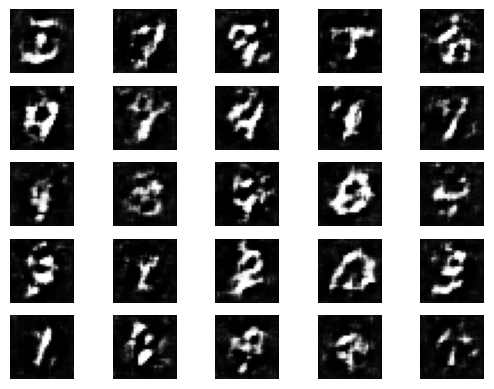

4/4 [==============================] - 0s 3ms/step
451 [D loss: 0.514729, acc.: 76.56%] [G loss: 0.828855]
4/4 [==============================] - 0s 6ms/step
452 [D loss: 0.411467, acc.: 87.11%] [G loss: 0.884479]
4/4 [==============================] - 0s 6ms/step
453 [D loss: 0.322636, acc.: 93.36%] [G loss: 0.912823]
4/4 [==============================] - 0s 3ms/step
454 [D loss: 0.458926, acc.: 84.77%] [G loss: 0.844200]
4/4 [==============================] - 0s 7ms/step
455 [D loss: 0.693534, acc.: 55.08%] [G loss: 0.934403]
4/4 [==============================] - 0s 4ms/step
456 [D loss: 0.470069, acc.: 80.47%] [G loss: 0.987517]
4/4 [==============================] - 0s 8ms/step
457 [D loss: 0.706199, acc.: 54.69%] [G loss: 0.847624]
4/4 [==============================] - 0s 5ms/step
458 [D loss: 0.566257, acc.: 71.48%] [G loss: 0.927442]
4/4 [==============================] - 0s 5ms/step
459 [D loss: 0.606889, acc.: 67.19%] [G loss: 0.851248]
4/4 [==============================] 

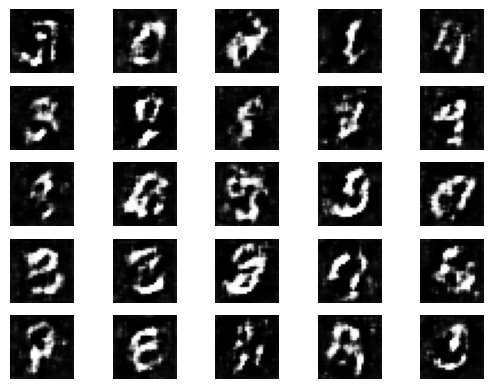

In [ ]:
dcgan = DCGAN()

dcgan.train(epochs=501, batch_size=128, sample_interval=50)